In [20]:
#!/usr/bin/env python3
import os
import glob
import argparse
import yaml
import matplotlib.pyplot as plt



In [21]:
base_folder = 'results-event-with-direction-ap'
experiment_name = 'event-with-direction-ap'

# Find all subdirectories that match the pattern "no.*"
folder_paths = [f for f in glob.glob(os.path.join(base_folder, "no.*")) if os.path.isdir(f)]

if not folder_paths:
    print("No folders matching 'no.*' were found.")
    assert 0

In [22]:
# Dictionary to store AP values for each folder (key: folder name, value: list of AP values)
summary_data = {}

for folder in folder_paths:
    result_yaml_path = os.path.join(folder, "results.yaml")
    if not os.path.exists(result_yaml_path):
        print(f"result.yaml not found in {folder}, skipping.")
        continue

    with open(result_yaml_path, "r") as f:
        data = yaml.safe_load(f)
    
    if "AP_results" not in data:
        print(f"AP_results not found in {result_yaml_path}, skipping.")
        continue
    
    ap_values = []
    for fold_key, result in data["AP_results"].items():
        # Expecting each fold's result to be a dict with key "average_precision"
        if isinstance(result, dict) and "average_precision" in result:
            ap_values.append(result["average_precision"])
        else:
            print(f"Invalid AP data for {fold_key} in {folder}, skipping that fold.")

    ## For reverse
    for fold_key, result in data["inv_AP_results"].items():
        # Expecting each fold's result to be a dict with key "average_precision"
        if isinstance(result, dict) and "average_precision" in result:
            ap_values.append(result["average_precision"])
        else:
            print(f"Invalid AP data for {fold_key} in {folder}, skipping that fold.")
    
    config_yaml_path = os.path.join(folder, "used_config.yaml")
    if not os.path.exists(config_yaml_path):
        print(f"used_config.yaml not found in {folder}, skipping.")
        continue

    with open(config_yaml_path, "r") as f:
        data = yaml.safe_load(f)

    if "data" not in data:
        print(f"data not found in {config_yaml_path}, skipping.")
        continue

    folder_name = data['data']['npy_path']
    folder_name = os.path.basename(folder_name)
    folder_name_split = folder_name.split('.')
    folder_mouse_and_day = f'{folder_name_split[1]}_{folder_name_split[3]}'
    
    
    if ap_values:
        # folder_name = os.path.basename(folder)
        summary_data[folder_mouse_and_day] = ap_values

In [23]:
import numpy as np
import pandas as pd

folder_names = sorted(summary_data.keys())
mean_list = [np.mean(summary_data[name]) for name in folder_names]
median_list = [np.median(summary_data[name]) for name in folder_names]
std_list = [np.std(summary_data[name]) for name in folder_names]

df = {'recording_name': folder_names, 'mean': mean_list, 'median': median_list, 'std': std_list}
df = pd.DataFrame(df)
output_path = os.path.join(base_folder, f"{experiment_name}_summary.csv")
df.to_csv(output_path, index=False)

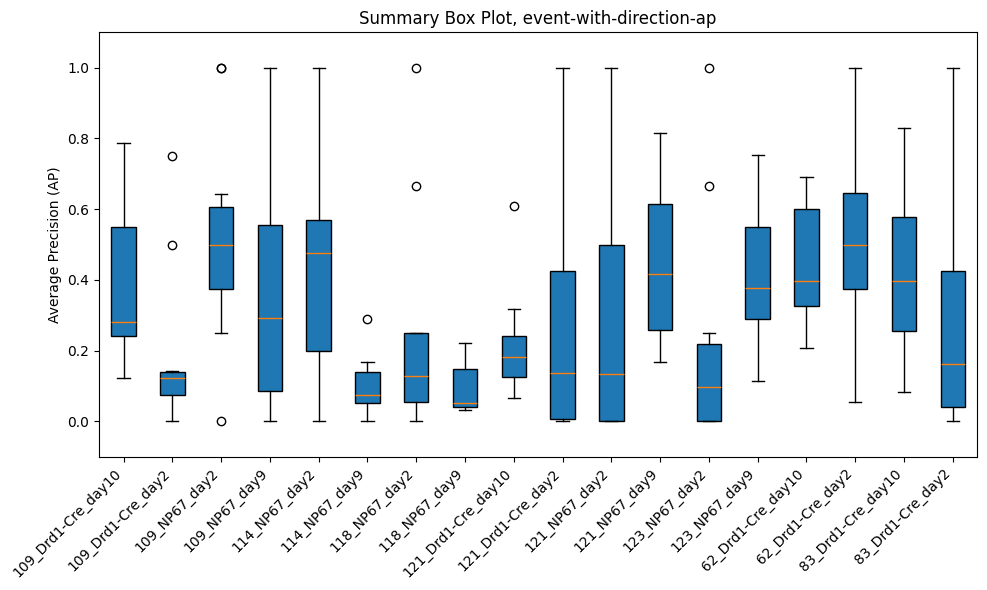

Box plot saved to results-event-with-direction-ap/event-with-direction-ap_summary_boxplot.eps


In [24]:




# if not summary_data:
#     print("No valid AP data found in any folder.")
#     return

# Prepare data for the box plot: each box represents one folder's AP distribution.
folder_names = sorted(summary_data.keys())
data_list = [summary_data[name] for name in folder_names]

plt.figure(figsize=(10, 6))
plt.boxplot(data_list, patch_artist=True)
plt.xticks(range(1, len(folder_names) + 1), folder_names, rotation=45, ha="right")
plt.ylabel("Average Precision (AP)")
plt.title(f"Summary Box Plot, {experiment_name}")
plt.tight_layout()
plt.ylim([-0.1, 1.1])
# Save the box plot in the base folder.
output_path = os.path.join(base_folder, f"{experiment_name}_summary_boxplot.png")
plt.savefig(output_path)
output_path = os.path.join(base_folder, f"{experiment_name}_summary_boxplot.eps")
plt.savefig(output_path)
plt.show()
plt.close()

print(f"Box plot saved to {output_path}")

